In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm



## Import and Clean Data

### Drop NaN Values and Fix Production Companies/Genres

In [2]:
df = pd.read_csv("Data_API/TMDB_movie_dataset_v11.csv")

In [3]:
df = df.dropna(subset=["budget","revenue", "production_companies"])
df = df[df["budget"] > 100000]

### Adjust for inflation

### Fix Production Companies, Genre, and Regions

In [4]:
df["production_companies"] = df["production_companies"].str.split(",")
df = df.explode("production_companies")
df["production_companies"] = df["production_companies"].str.strip()

In [5]:
df["genres"] = df["genres"].str.split(",")
df = df.explode("genres")
df["genres"] = df["genres"].str.strip()

In [6]:
df["production_countries"] = df["production_countries"].str.split(",")
df = df.explode("production_countries")
df["production_countries"] = df["production_countries"].str.strip()

## Feature Engineering:
### Calculate ROI

In [7]:
df["roi"] = (df["revenue"] - df["budget"])/df["budget"]

### Create List of Top American Studios

In [8]:
df = df[df["production_countries"] == "United States of America"]
unique_movies = df.drop_duplicates(subset=["title", "production_companies"])
unique_movies = unique_movies.groupby("production_companies").count().sort_values("id", ascending=False)
top_studios = unique_movies.loc[unique_movies["id"] >= 50].index

### Filter Movies for Major Studios

In [9]:
df = df[df["production_companies"].isin(top_studios)]

In [10]:
df = df[["title", "budget", "revenue", "genres", "production_companies", "roi"]]

### Get Rotten Tomatoes Data

In [158]:
rt1 = pd.read_csv("Data/rt.movie_info.tsv",delimiter="\t")
rt1.info()
rt2 = pd.read_csv("Data/rt.reviews.tsv", delimiter="\t", encoding='windows-1252')
rt2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


## Analyze Data
### Visualization 1: Production Budgets and ROIs

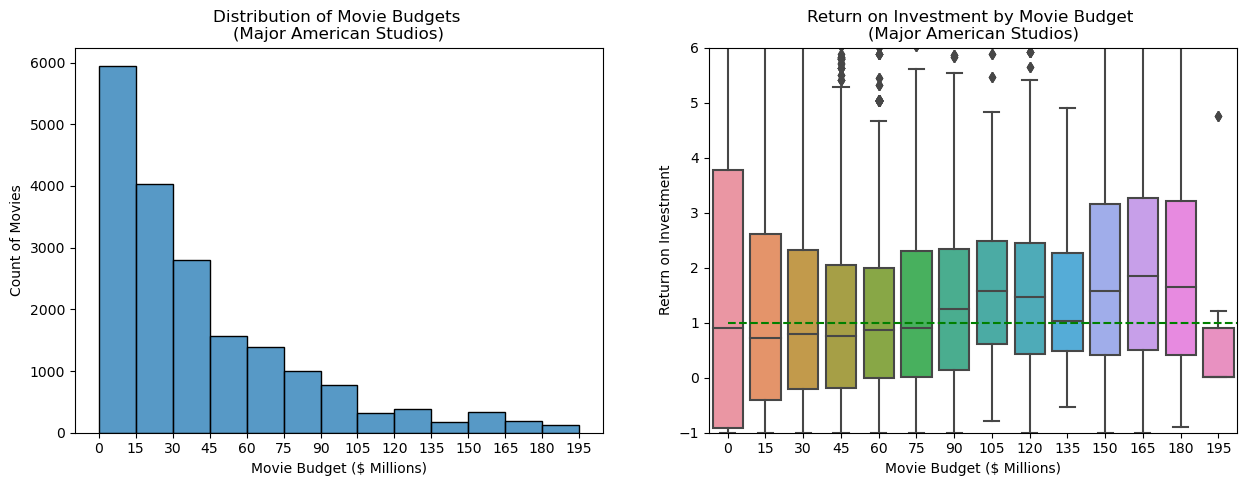

In [196]:
fig, ax = plt.subplots(1,2, figsize=[15, 5])
sns.histplot(data=df, x="budget", bins=np.arange(0,210000000,15000000), ax=ax[0])
ax[0].set_title("Distribution of Movie Budgets \n(Major American Studios)")
ax[0].set_xlabel("Movie Budget ($ Millions)")
ax[0].set_ylabel("Count of Movies")

tick_labels = [str(x) for x in np.arange(0,205,15)]
ax[0].set_xticks(np.arange(0,200000000, 15000000), labels=tick_labels)



df["budget_bin"] = (df["budget"] // 15000000 + 1) * 15000000 
sns.boxplot( data=df[df["budget"]<200000000], x="budget_bin", y="roi", ax=ax[1])
ax[1].set_ylim(-1, 6)
ax[1].hlines(y=1, xmin=0, xmax=13.5, color="g", linestyles="dashed" );

ax[1].set_title("Return on Investment by Movie Budget \n(Major American Studios)")
ax[1].set_xlabel("Movie Budget ($ Millions)")
ax[1].set_ylabel("Return on Investment")
ticks = [x for x in np.arange(0,14,1)]
len(ticks)
tick_labels = [str(x) for x in np.arange(0,205,15)]
ax[1].set_xticks(ticks, labels=tick_labels)

fig.savefig("Presentation/Images/overview_studios.png", bbox_inches="tight")


### Visualization 2: Average ROI vs. Production Company

Index(['Paramount', 'Columbia Pictures', 'Universal Pictures'], dtype='object', name='production_companies')

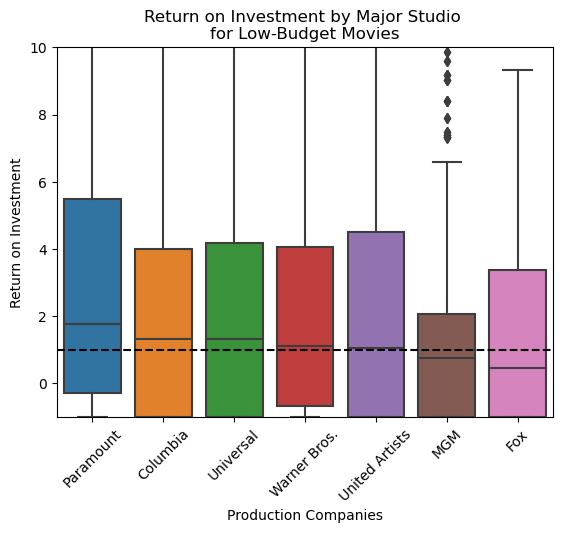

In [108]:
df_low_budget = df[df["budget"] < 15000000]
df_low_budget = df_low_budget.groupby("production_companies").count()
studio_low_budget = list(df_low_budget[df_low_budget["roi"] > 200].index)

temp = df.loc[(df["budget"] < 15000000) & (df["production_companies"].isin(studio_low_budget)), ["production_companies","roi"]]
studios_ordered = temp.groupby("production_companies").median().sort_values("roi", ascending=False).index

fig, ax = plt.subplots()
sns.boxplot(data=temp, x="production_companies", y="roi", order=studios_ordered, ax=ax)
ax.hlines(y=1.0, xmin=-0.5, xmax=6.5, color="black", linestyles="dashed")
ax.set_ylim(-1, 10)
ax.set_xlabel("Production Companies")
ax.set_ylabel("Return on Investment")
ax.set_title("Return on Investment by Major Studio \nfor Low-Budget Movies")

ax.set_xticklabels(["Paramount", "Columbia", "Universal", "Warner Bros.", "United Artists", "MGM", "Fox"])
ax.tick_params("x", labelrotation=45)

fig.savefig("Presentation/Images/roi_studio_low_budget.png", bbox_inches="tight")

target_studios = studios_ordered[:3]
target_studios

### Visualization 3: Successful Genres

Half of the successful low-budget movies made by these production companies are either comedy, drama.

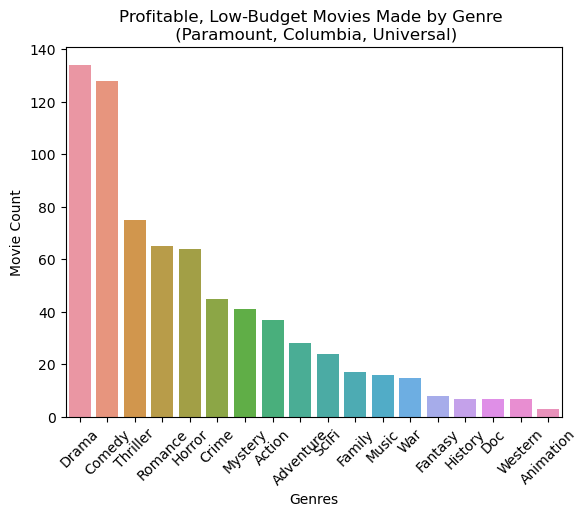

In [130]:
df_low_budget2 = df[df["budget"] < 15000000]
genres_count_successful = df_low_budget2.loc[(df_low_budget2["production_companies"].isin(target_studios)) & (df_low_budget2["roi"] > 1),"genres"].value_counts()

genres = list(genres_count_successful.index)
genres[9] = "SciFi"
genres[-3] = "Doc"

fig, ax = plt.subplots()
sns.barplot(x=genres, y=genres_count_successful.values, ax=ax)
ax.tick_params("x", labelrotation=45)
ax.set_xlabel("Genres")
ax.set_ylabel("Movie Count")
ax.set_title("Profitable, Low-Budget Movies Made by Genre \n (Paramount, Columbia, Universal)")
fig.savefig("Presentation/Images/genre_distribution_lowbudget.png", bbox_inches="tight")

target_genres = ["Drama", "Comedy"]

### Visualization 4: 

In [159]:
rt1 = rt1[rt1["studio"].isin(target_studios)]
rt1 = rt1.dropna(subset="box_office")
rt1["box_office"] = rt1["box_office"].str.replace(",","").astype(float)

In [160]:
rt2["fresh_bool"] = rt2["fresh"] == "fresh"
rt2 = rt2[["id", "fresh_bool"]].groupby("id").mean()
box_office_fresh = rt1[["id","box_office"]].merge(rt2, left_on="id", right_on="id")

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.892
Date:                Fri, 04 Oct 2024   Prob (F-statistic):              0.179
Time:                        08:04:20   Log-Likelihood:                -659.79
No. Observations:                  34   AIC:                             1324.
Df Residuals:                      32   BIC:                             1327.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.316e+07    2.4e+07      2.219      0.0

,fresh_bool,box_office
fresh_bool,1.000000,0.236282
box_office,0.236282,1.000000


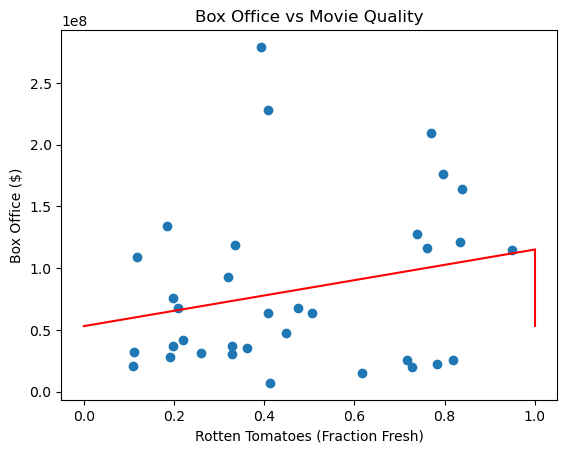

In [168]:
model = sm.regression.linear_model.OLS(endog=box_office_fresh["box_office"], exog=sm.add_constant(box_office_fresh["fresh_bool"]))
results = model.fit()
print(results.summary())

x = sm.add_constant(np.linspace(0,1) )
y_predict = results.predict(x)

fig, ax = plt.subplots()
ax.scatter(x=box_office_fresh["fresh_bool"], y=box_office_fresh["box_office"])
ax.plot(x, y_predict, color="r")
ax.set_xlabel("Rotten Tomatoes (Fraction Fresh)")
ax.set_ylabel("Box Office ($)")
ax.set_title("Box Office vs Movie Quality")

fig.savefig("Presentation/Images/freshBool_boxOffice.png", bbox_inches="tight")

box_office_fresh[["fresh_bool", "box_office"]].corr()